# Collaborative filtering with FastAI

Collaborative filtering is a technique used by recommender systems to make predictions about the preferences of a user by collecting preferences from many users. The underlying assumption is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue than that of a randomly chosen person.

In [2]:
import os
import opendatasets as od

In [3]:
od.download(
    "https://www.kaggle.com/prajitdatta/movielens-100k-dataset",
    "../data",
)

Skipping, found downloaded files in "../data/movielens-100k-dataset" (use force=True to force download)


In [4]:
os.listdir("../data/movielens-100k-dataset/ml-100k/")

['u.item',
 'u3.test',
 'u1.base',
 'u.info',
 'u2.test',
 'u5.test',
 'u.genre',
 'ub.test',
 'ua.base',
 'u.data',
 'README',
 'u4.test',
 'u5.base',
 'ub.base',
 'ua.test',
 'u4.base',
 'u.user',
 'allbut.pl',
 'u3.base',
 'u1.test',
 'mku.sh',
 'u2.base',
 'u.occupation']

In [5]:
!head "../data/movielens-100k-dataset/ml-100k/u.data"

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


In [6]:
import pandas as pd
from fastai.collab import CollabDataLoaders, collab_learner

Read the data from the CSV file `u.data` into dataframe, and create a FastAI `DataBunch` object.

1. Converts the Pandas data frame into tensors
2. It splits the data into a training set and a validation set
3. Creates data loaders to access the data in batches
4. Check if a GPU is available, and moves the data to the GPU

In [7]:
cols = ["User ID", "Movie ID", "Rating", "Timestamp"]
ratings_df = pd.read_csv(
    "../data/movielens-100k-dataset/ml-100k/u.data",
    delimiter="\t",
    header=None,
    names=cols,
)
ratings_df.sample(5)

,User ID,Movie ID,Rating,Timestamp
64056,588,1074,5,890032056
43997,670,651,4,877975070
80400,943,421,2,888639351
45503,445,340,5,891035571
25616,182,111,4,885613238


In [11]:
data = CollabDataLoaders.from_df(ratings_df, valid_pct=0.1, bs=64)
data.show_batch()

,User ID,Movie ID,Rating
0,524,614,5
1,533,430,5
2,312,529,5
3,64,731,3
4,319,259,2
5,1,52,4
6,489,689,5
7,132,251,4
8,561,661,4
9,297,216,4


## Collaborative filtering model

Represent each user `u` and each movie `m` by vector of a predefined length `n`. The rating for the movie `m` by the user `u`, as predicted by the model is simply the dot product of the two vectors.

Since the vectors are chosen randomly, it's quite unlikely that the ratings predicted by the model match the actual ratings. The objective while training the model is to gradually adjust the elements inside the user & movie vectors so that predicted ratings get closer to the actual ratings.

Use the `collab_learner` method from `fastai` to create a neural collaborative filtering model.

In [12]:
learner = collab_learner(
    data,
    n_factors=40,  # The number of factors to use (i.e. the size of the embedding vectors)
    y_range=[
        0,
        5.5,
    ],  # The range of the ratings (the predictions will be clipped to this range), 1-5 but let it vary a bit
    wd=0.1,  # Weight decay to ensure the model doesn't overfit
)

The actual model created here contains 2 enhancements on the simpler model described above:

1. Apart from the vectors for users and movies, it also add bias terms to account for outliers. For instance, some users may tend to give higher ratings than others, and some movies may be consistently underrated.

2. The model applies the Sigmoid activation function to the predicted ratings and scales the ratings to the given `y_range` (in this case, between 0 and 5.5).

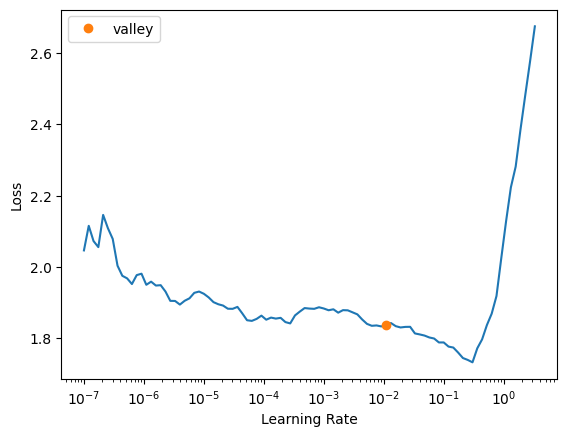

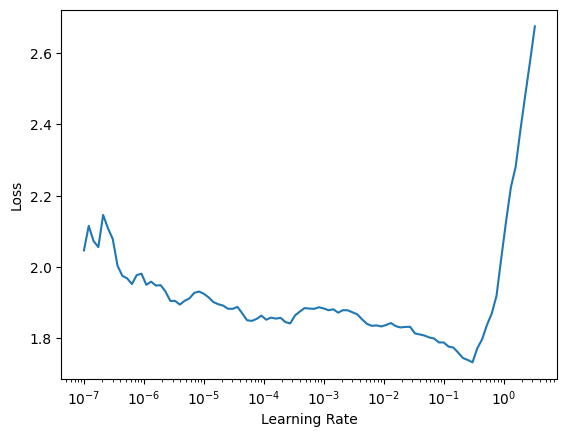

In [15]:
learner.lr_find()
learner.recorder.plot_lr_find()

In [16]:
learner.fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,time
0,0.875414,0.956351,00:48
1,0.670339,0.921789,00:44
2,0.577429,0.898983,00:47
3,0.470938,0.858918,00:48
4,0.457653,0.851197,00:43


## Looking at some predictions

In [120]:
valid_dl = data.valid
preds = learner.get_preds(dl=valid_dl)
for i in range(16):
    print(f"Prediction: {preds[0][i].item():.2f}, Actual: {preds[1][i].item()}")

Prediction: 3.78, Actual: 4
Prediction: 2.91, Actual: 2
Prediction: 3.65, Actual: 3
Prediction: 3.23, Actual: 2
Prediction: 3.35, Actual: 4
Prediction: 3.69, Actual: 4
Prediction: 2.79, Actual: 3
Prediction: 3.82, Actual: 4
Prediction: 4.40, Actual: 5
Prediction: 2.52, Actual: 3
Prediction: 4.31, Actual: 5
Prediction: 4.11, Actual: 3
Prediction: 4.23, Actual: 5
Prediction: 4.80, Actual: 5
Prediction: 3.30, Actual: 5
Prediction: 3.02, Actual: 4
